<a href="https://colab.research.google.com/github/khpankiv/Kaggle_learning/blob/main/ell_feedback_regres_1_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

In [ ]:
# A dependency of the preprocessing for BERT inputs
#!pip install -q -U "tensorflow-text==2.8.*"

In [ ]:

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt

2022-12-20 18:05:52.402019: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-20 18:05:52.402319: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# **Read the datasets**

In [ ]:
#! cp /mnt/c/users/Khrystyna/Downloads/kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
train= pd.read_csv("./ELL/train.csv")
#test= pd.read_csv("./ELL/test.csv")
#test_sub=pd.read_csv("./ELL/sample_submission.csv")

In [ ]:
train = train.sample(frac = 0.1)
test = train.iloc[:,0:2]
test_sub = train.iloc[:,[0,2]]

Data preprocessing: changing grades into integer

In [ ]:
num_text = test_sub.shape[1]
#batch_size = 32
#num_baches = round(num_text/batch_size)
#num_text = num_baches*batch_size
columns = ['text_id','cohesion']
train_X = train[:].full_text.values
#np.reshape(train_X,(batch_size,num_baches))
train_Y_n = (train.iloc[:,2].values)*2-2
#np.reshape(train_Y_n,(batch_size,num_baches))
#train_Y = tf.keras.utils.to_categorical(train_Y_n)
train_Y = train_Y_n
test_X = train_X
test_id = test.text_id.values
test_Y = (train.iloc[:,2].values)
#np.reshape(test_Y,(batch_size,num_baches))

In [ ]:
distribution = train['cohesion']. value_counts(1).sort_index()
#distr=distribution.values
distr = dict(zip(range(9), 1/distribution.values))

# **Define the model**
A simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense with Softmax output and a Dropout layer.

Add BERT models

In [ ]:
tfhub_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
tfhub_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [ ]:
  #preprocess_model = hub.KerasLayer(tfhub_preprocess)
  #encoder_inputs = preprocess_model(train_X)
  #encoder = hub.KerasLayer(tfhub_encoder, trainable=False)
  #outputs = encoder(encoder_inputs)
  #output = outputs['pooled_output']

In [ ]:
#input_shape = output.shape[1]

In [ ]:
def build_classifier_model(activ,num_output):
  text_input = tf.keras.layers.Input(shape = (),batch_size = 1, dtype=tf.string, name = 'text')
  preprocessing_layer = hub.KerasLayer(tfhub_preprocess)
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_encoder, trainable=True)
  outputs = encoder(encoder_inputs)
  output = outputs['pooled_output']
  #output = tf.keras.layers.Dense(256,activation='ReLU')(output)
  #output = tf.keras.layers.Dense(128, activation='ReLU')(output)
  #output = tf.keras.layers.Dense(64, activation='ReLU')(output) 
  #output = tf.keras.layers.Dense(32, activation='ReLU')(output)
  #output = tf.keras.layers.Dense(16, activation='ReLU')(output)
  output = tf.keras.layers.Dense(9, activation='ReLU')(output)
#net_1 = tf.keras.layers.Dropout(0.1)(output_2)
  net_1 = tf.keras.layers.Dense(9, activation = activ)(output)
 # net_1 = tf.keras.layers.Dense(num_output, activation=activ,name = 'clas_1')(net_1)
  return tf.keras.Model(text_input, net_1)

In [ ]:
classifier_model = build_classifier_model('softmax',9)

2022-12-20 18:06:03.521506: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-20 18:06:03.521878: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-20 18:06:03.521976: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-VMHF4TO): /proc/driver/nvidia/version does not exist
2022-12-20 18:06:03.523999: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# **Model training**

In [ ]:
epochs = 10
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction = 'sum_over_batch_size')

In [ ]:
   # from google3.third_party.tensorflow.core.protobuf import rewriter_config_pb2
    #    config_proto = tf.ConfigProto()
#    off = rewriter_config_pb2.RewriterConfig.OFF
 #   config_proto.graph_options.rewrite_options.arithmetic_optimization = off
  #    session = tf.Session(config=config_proto)

In [ ]:
#    #config_proto = tf.ConfigProto(log_device_placement=False, allow_soft_placement=True)
 #   off = rewriter_config_pb2.RewriterConfig.OFF
 #   config_proto.graph_options.rewrite_options.arithmetic_optimization = off
#    sess = tf.Session(config=config_proto)

In [ ]:
classifier_model.compile(optimizer = 'adam',
                         loss = loss,
                         metrics = 'accuracy')

In [ ]:
history = classifier_model.fit(x = train_X,
                               y = train_Y,
                               epochs = epochs,
                               batch_size=1, 
                               class_weight = distr)

Epoch 1/10
  2/391 [..............................] - ETA: 7:10 - loss: 147.6494 - accuracy: 0.0000e+00   

# **Model evaluation**

In [ ]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy'])


/tmp/ipykernel_2358/2994192602.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,1,1)


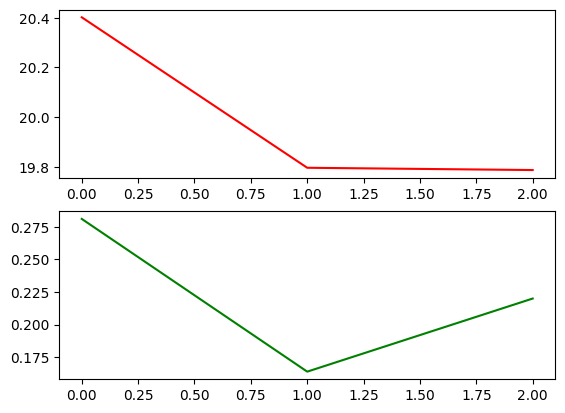

In [ ]:
i = range(epochs)
plt.figure(1)
plt.title('Model evaluation')
plt.legend()

plt.subplot(2,1,1)
plt.plot(i,history_dict['loss'],'r',label = "Training loss")

plt.subplot(2,1,2)
plt.plot(i,history_dict['accuracy'],'g',label = "Training MSE")



In [ ]:
t = test_X[0:5]

In [ ]:
test_Y_n = classifier_model.predict(t,verbose = 1)

1/1 [==============================] - 1s 1s/step


In [ ]:
print(test_Y_n)

[[0.08856932 0.10999403 0.11645661 0.11399987 0.1168026  0.1158528
  0.11144223 0.11481254 0.11206998]
 [0.08856932 0.10999403 0.11645661 0.11399987 0.1168026  0.1158528
  0.11144223 0.11481254 0.11206998]
 [0.08856932 0.10999403 0.11645661 0.11399987 0.1168026  0.1158528
  0.11144223 0.11481254 0.11206998]
 [0.08856932 0.10999403 0.11645661 0.11399987 0.1168026  0.1158528
  0.11144223 0.11481254 0.11206998]
 [0.08856932 0.10999403 0.11645661 0.11399987 0.1168026  0.1158528
  0.11144223 0.11481254 0.11206998]]


In [ ]:
pred_test_Y=(np.argmax(test_Y_n,1)+2)/2
pred_Y=np.transpose(pred_test_Y)

In [ ]:
print(pred_test_Y)

[3. 3. 3. 3. 3.]


In [ ]:
mcrmse_test = (1/(np.sqrt(num_text)))*np.sum(np.sqrt(np.sum(np.square(pred_Y-test_Y[0:5]),axis=0)))
print('MCRMSE = ',mcrmse_test) 

MCRMSE =  1.118033988749895


MCRMSE =  0.617284905504784 5 epochs

MCRMSE =  0.6333342304873718 10 epochs

MCRMSE =  0.6012389019459027 10 epochs bached 32

MCRMSE =  0.6137303634466796 5 epochs batched tuned

MCRMSE =  0.5939521873178615 5 epochs 2 dense
  
MCRMSE =  0.5827963961318415 10 epochs 5 dense

MCRMSE =  0.47713642331475004  1 epoch 3 dense shaped

# **create output file**

In [ ]:
#np.reshape(pred_Y,(num_text))
result = [test_id, pred_Y]
df_result = pd.DataFrame(np.transpose(result),columns = columns)

clear the /kaggle/working

In [ ]:
print(pred_Y)

[3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5
 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5
 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5
 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5
 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5
 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5
 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5
 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5
 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5
 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5
 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5
 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5
 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5
 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.

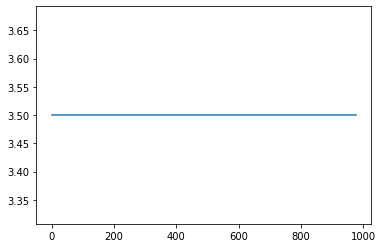

In [ ]:
i = range(num_text)
plt.plot(i,df_result.iloc[:,1])

In [ ]:
df_result.to_csv('/kaggle/working/submission.csv')